## Made with guiding "Finetuning from a pretrained model"
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#finetuning-from-a-pretrained-model
- https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/


Para probar
https://www.kaggle.com/code/chekoduadarsh/pytorch-beginner-code-faster-rcnn/comments

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

from src.detection.engine import train_one_epoch, evaluate
# from src.anchor_generator import CustomAnchorGenerator

In [3]:
import os
import numpy as np
import pandas as pd
import random
import torch
from PIL import Image
from typing import Sequence
import torch
import torchvision
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.transforms import ToTensor, RandomRotation, functional, Compose, Normalize, ConvertImageDtype, PILToTensor
from torchvision.ops.feature_pyramid_network import LastLevelP6P7

import logging

In [4]:
# Windows
# PATH = 'C:\\Users\\Diego\\Desktop\\TFI-Cazcarra'
# Linux
PATH = "/home/nacho/TFI-Cazcarra"

ELEMENT_TO_TRAIN = "diagramas"

# IMAGES_DIR = f"{PATH}\\data\\imagenes_diagramas"
IMAGES_DIR = f"{PATH}/data/imagenes_diagramas"
CLASSES_CSV = f"{PATH}/data/csv/classes_{ELEMENT_TO_TRAIN}.csv"
TRAIN_CSV = f"{PATH}/data/csv/train_{ELEMENT_TO_TRAIN}.csv"
TEST_CSV = f"{PATH}/data/csv/test_{ELEMENT_TO_TRAIN}.csv"
VAL_CSV = f"{PATH}/data/csv/val_{ELEMENT_TO_TRAIN}.csv"

In [5]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
val_df = pd.read_csv(VAL_CSV)

In [6]:
# Linux - Fix despues mas adelante

train_df['image_path'] = train_df['image_path'\
                                 ].apply(lambda x: x.replace("\\","/").replace(\
                                                "C:/Users/Diego/Desktop/TFI-Cazcarra",PATH))

test_df['image_path'] = test_df['image_path'\
                                 ].apply(lambda x: x.replace("\\","/").replace(\
                                                "C:/Users/Diego/Desktop/TFI-Cazcarra",PATH))

val_df['image_path'] = val_df['image_path'\
                                 ].apply(lambda x: x.replace("\\","/").replace(\
                                                "C:/Users/Diego/Desktop/TFI-Cazcarra",PATH))

In [7]:
train_df = pd.read_csv("/home/nacho/TFI-Cazcarra/data/csv/augmented_train_diagramas.csv", header=None)
train_df.columns = ['image_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label']

test_df = pd.read_csv("/home/nacho/TFI-Cazcarra/data/csv/augmented_test_diagramas.csv")
# test_df.columns = ['image_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label']

In [8]:
train_df = train_df[train_df['label']=="tabla"]
test_df = test_df[test_df['label']=="tabla"]

In [9]:
train_df.head()

,image_path,xmin,ymin,xmax,ymax,label
0,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,101,155,330,341,tabla
1,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,451,174,617,318,tabla
2,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,687,23,933,304,tabla
3,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,1013,95,1160,212,tabla
4,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,878,468,1007,666,tabla


In [10]:
test_df.head()

,image_path,xmin,ymin,xmax,ymax,label
0,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,276,148,430,619,tabla
1,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,541,501,692,819,tabla
2,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,745,149,897,463,tabla
9,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,332,140,491,267,tabla
10,/home/nacho/TFI-Cazcarra/data/imagenes_diagram...,331,376,500,525,tabla


In [11]:
from sklearn.preprocessing import LabelEncoder

classes = pd.read_csv(CLASSES_CSV)
le = LabelEncoder()
le.fit(classes.nombre)

le_num_arr = le.transform(classes.nombre) + 1 #Empezamos por 1 para dejarle el 0 a la 'background class'
le_label_arr = classes.nombre.values

le_dict = {k:v for k,v in zip(le_label_arr,le_num_arr)}

le_dict = {'tabla': 1}
num_classes = len(le_dict) + 1

In [12]:
class DiagramasDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, csv, le_dict, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.csv = csv
        self.images = [i for i in os.listdir(self.images_dir) \
                       if os.path.join(self.images_dir, i) in self.csv['image_path'].unique()]
        self.le_dict = le_dict
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        image_path = self.images[idx]
        full_image_path = os.path.join(self.images_dir, image_path)
        df = self.csv
        filtered_df = df[df['image_path']==full_image_path]
        number_of_objects = filtered_df.shape[0]
        
        image = Image.open(full_image_path).convert("RGB")
        
        boxes = []
        for xmin, ymin, xmax, ymax in zip(filtered_df['xmin'], filtered_df['ymin'], filtered_df['xmax'], filtered_df['ymax']):
            boxes.append([xmin, ymin, xmax, ymax])       
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = [self.le_dict[label] for label in filtered_df['label'].values]
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = torch.zeros((number_of_objects,), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        
        return image, target
                
    def __len__(self):
        return len(self.images)

In [13]:
class CustomRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return functional.rotate(x, int(angle))

In [14]:
def transform_compose(train):
    transforms = []
    transforms.append(PILToTensor())
    transforms.append(ConvertImageDtype(torch.float))
#     if train:
#         angles = np.arange(0,360,90)
#         transforms.append(CustomRotateTransform(angles=angles))
    return Compose(transforms)

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_dataset = DiagramasDataset(images_dir=IMAGES_DIR, csv=train_df, le_dict=le_dict, \
                                 transform=transform_compose(train=True))

BATCH_SIZE = 4
SHUFFLE = True

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                                          shuffle=SHUFFLE, num_workers=0,\
                                          collate_fn=collate_fn)

In [17]:
test_dataset = DiagramasDataset(images_dir=IMAGES_DIR, csv=test_df, le_dict=le_dict, \
                                 transform=transform_compose(train=False))

BATCH_SIZE_TEST = 16

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, \
                                          shuffle=SHUFFLE, num_workers=0,\
                                          collate_fn=collate_fn)

In [18]:
from torchvision.models import ResNet50_Weights

backbone = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

trainable_backbone_layers = 2

trainable_backbone_layers = _validate_trainable_layers(
        True, trainable_backbone_layers, 4, 3
    )

backbone = _resnet_fpn_extractor(
        backbone, trainable_backbone_layers, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256)
    )

for param in backbone.parameters():
    param.requires_grad = False

# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

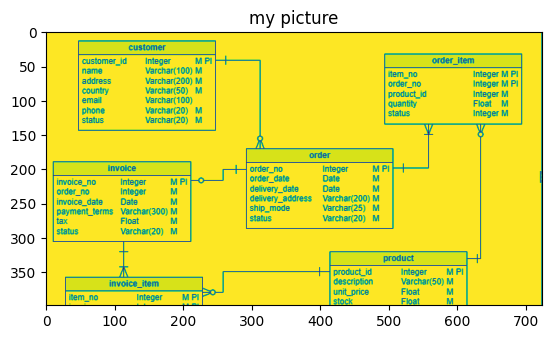

In [19]:
from matplotlib import pyplot as plt
import cv2

ten = torch.Tensor.numpy(train_dataset.__getitem__(0)[0])

plt.imshow(ten[0,:,:])
plt.title('my picture')
plt.show()

In [20]:
scales = (0.532, 0.641, 0.757, 0.841, 0.959)
# sizes = tuple(tuple(size*scale for size in (32,64,128,256,512)) for scale in scales)
sizes = tuple((32,64,128,256,512),)
ratios = ((0.48, 0.737, 1.0, 1.356, 2.083))

#Cuando se usa FPN, size y aspect_ratios no tienen que estar "double-nested" -> ((x,y,z,w),)
anchor_generator = AnchorGenerator(sizes=sizes,\
                                   aspect_ratios=ratios,
                                   )

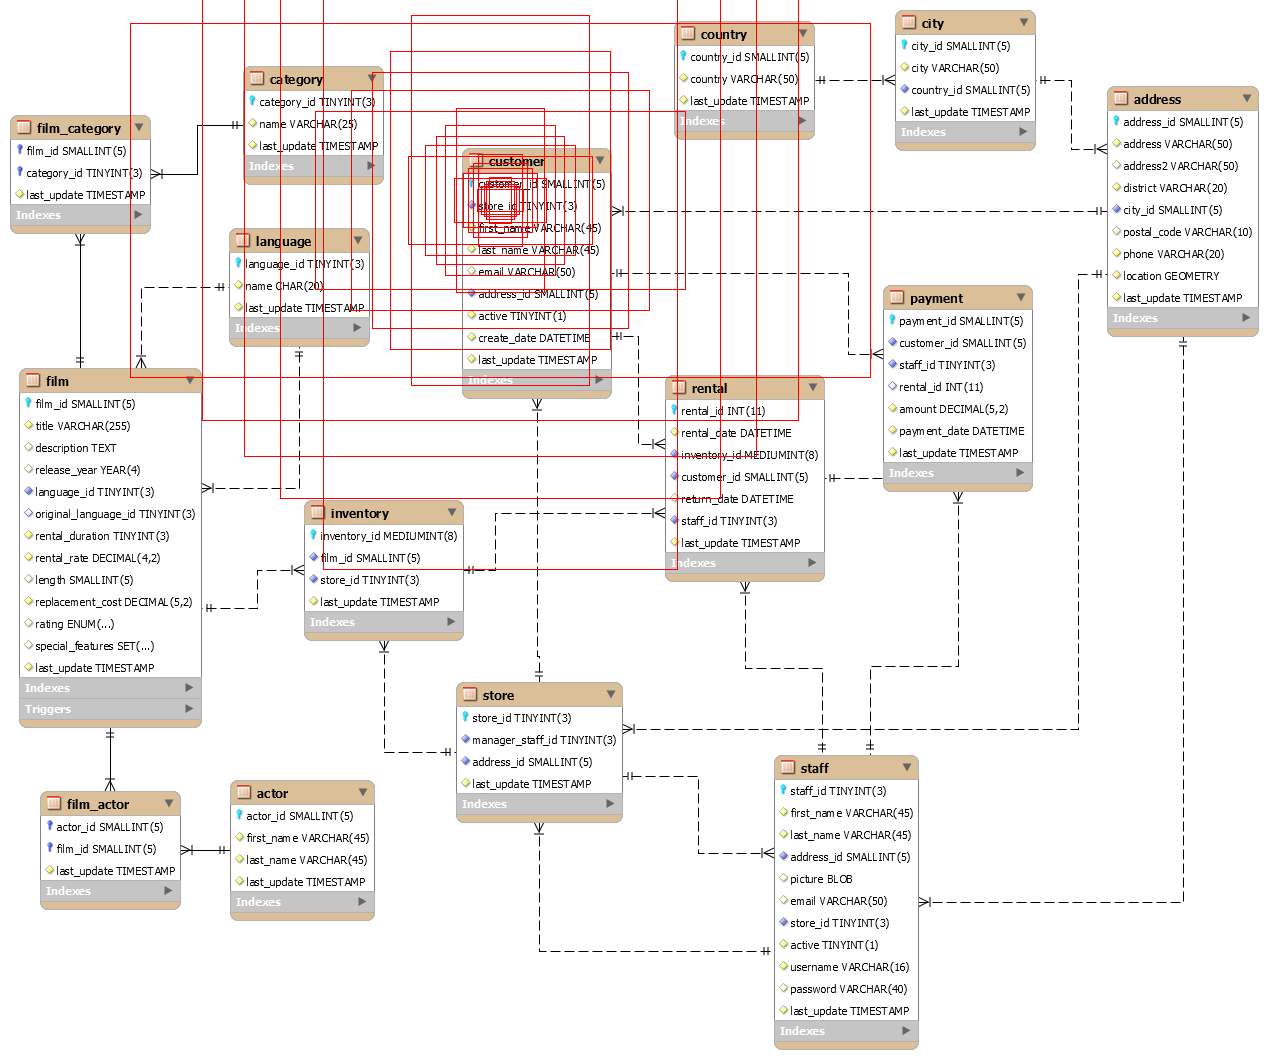

In [21]:
def draw_bbox(img, xmin, ymin, xmax, ymax):
    return cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), 
                         (255,0,0), 1)
    

ten2 = cv2.imread("/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-12.png")

for anchor_tensor in anchor_generator.cell_anchors:
    for anchor in anchor_tensor:
        try:
            ten2 = draw_bbox(ten2, xmin=anchor[0].item()+500, ymin=anchor[1].item()+200, 
                          xmax=anchor[2].item()+500, ymax=anchor[3].item()+200)
        except Exception as e:
            print(e)

Image.fromarray(ten2)

In [22]:
# print(isinstance(anchor_generator, torch.nn.Module))
# isinstance(anchor_generator, AnchorGenerator)

In [23]:
# ratios = (0.48, 0.737, 1.0, 1.356, 2.083)
# scales = (0.532, 0.641, 0.757, 0.841, 0.959)

# #Cuando se usa FPN, size y aspect_ratios no tienen que estar "double-nested" -> ((x,y,z,w),)
# anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512),\
#                                    aspect_ratios=ratios
#                                   )

In [24]:
minimum_size = 1000

# for img in os.listdir(IMAGES_DIR):
#     image = np.asarray(Image.open(os.path.join(IMAGES_DIR, img)))
#     minimum_size = min(minimum_size, image.shape[0])
#     minimum_size = min(minimum_size, image.shape[1])

In [25]:
# Segun la documentacion, 'num_classes (int): number of output classes of the model (including the background).'

print("Num classes: ", num_classes)
model = RetinaNet(backbone,
                  num_classes=num_classes,
                  anchor_generator=anchor_generator, 
                  min_size=minimum_size,
                  weights="RetinaNet_ResNet50_FPN_Weights")

Num classes:  2


In [26]:
# import math

# num_classes = len(classes)+1

# # replace classification layer 
# in_features = model.head.classification_head.conv[0][0].in_channels
# num_anchors = model.head.classification_head.num_anchors
# model.head.classification_head.num_classes = num_classes

# out_channels = model.backbone.out_channels
# cls_logits = torch.nn.Conv2d(out_channels, num_anchors * num_classes, kernel_size = 3, stride=1, padding=1)
# torch.nn.init.normal_(cls_logits.weight, std=0.01)  # as per pytorch code
# torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # as per pytorcch code 
# # assign cls head to model
# model.head.classification_head.cls_logits = cls_logits

In [27]:
LEARNING_RATE = 1e-3
EPOCHS = 100
DEVICE = 'cpu'

In [28]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

4789790

In [29]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=LEARNING_RATE,
                                momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [30]:
for epoch in range(1, EPOCHS+1):
    metric_logger = train_one_epoch(model, optimizer, train_dataloader, DEVICE, epoch, print_freq=3)
    del metric_logger
    lr_scheduler.step()
    evaluate(model, test_dataloader, device=DEVICE)

Epoch: [1]  [0/7]  eta: 0:03:07  lr: 0.001000  loss: 1.7939 (1.7939)  classification: 1.1313 (1.1313)  bbox_regression: 0.6627 (0.6627)  time: 26.7791  data: 0.1081
Epoch: [1]  [3/7]  eta: 0:01:49  lr: 0.001000  loss: 1.7934 (1.8055)  classification: 1.1313 (1.1323)  bbox_regression: 0.6579 (0.6731)  time: 27.4248  data: 0.1436
Epoch: [1]  [6/7]  eta: 0:00:26  lr: 0.001000  loss: 1.7934 (1.7955)  classification: 1.1313 (1.1319)  bbox_regression: 0.6579 (0.6637)  time: 26.9818  data: 0.1150
Epoch: [1] Total time: 0:03:08 (26.9823 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:53  model_time: 53.3373 (53.3373)  evaluator_time: 0.0031 (0.0031)  time: 53.4564  data: 0.1160
Test: Total time: 0:00:53 (53.4570 s / it)
Averaged stats: model_time: 53.3373 (53.3373)  evaluator_time: 0.0031 (0.0031)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.

Epoch: [6]  [0/7]  eta: 0:03:18  lr: 0.000100  loss: 1.8027 (1.8027)  classification: 1.1265 (1.1265)  bbox_regression: 0.6762 (0.6762)  time: 28.4260  data: 0.1277
Epoch: [6]  [3/7]  eta: 0:01:53  lr: 0.000100  loss: 1.7619 (1.7831)  classification: 1.1258 (1.1267)  bbox_regression: 0.6361 (0.6565)  time: 28.4253  data: 0.1196
Epoch: [6]  [6/7]  eta: 0:00:28  lr: 0.000100  loss: 1.7619 (1.7675)  classification: 1.1258 (1.1262)  bbox_regression: 0.6361 (0.6413)  time: 28.5058  data: 0.1085
Epoch: [6] Total time: 0:03:19 (28.5062 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:55  model_time: 55.1517 (55.1517)  evaluator_time: 0.0015 (0.0015)  time: 55.2663  data: 0.1130
Test: Total time: 0:00:55 (55.2666 s / it)
Averaged stats: model_time: 55.1517 (55.1517)  evaluator_time: 0.0015 (0.0015)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.

Epoch: [11]  [0/7]  eta: 0:03:01  lr: 0.000010  loss: 1.7727 (1.7727)  classification: 1.1250 (1.1250)  bbox_regression: 0.6477 (0.6477)  time: 25.8744  data: 0.0756
Epoch: [11]  [3/7]  eta: 0:01:42  lr: 0.000010  loss: 1.7651 (1.7729)  classification: 1.1247 (1.1255)  bbox_regression: 0.6406 (0.6474)  time: 25.6736  data: 0.0840
Epoch: [11]  [6/7]  eta: 0:00:26  lr: 0.000010  loss: 1.7651 (1.7649)  classification: 1.1247 (1.1253)  bbox_regression: 0.6406 (0.6396)  time: 26.5118  data: 0.1064
Epoch: [11] Total time: 0:03:05 (26.5121 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:53  model_time: 52.9831 (52.9831)  evaluator_time: 0.0014 (0.0014)  time: 53.0982  data: 0.1136
Test: Total time: 0:00:53 (53.0986 s / it)
Averaged stats: model_time: 52.9831 (52.9831)  evaluator_time: 0.0014 (0.0014)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ Io

Epoch: [16]  [0/7]  eta: 0:03:19  lr: 0.000001  loss: 1.7624 (1.7624)  classification: 1.1239 (1.1239)  bbox_regression: 0.6385 (0.6385)  time: 28.4861  data: 0.1864
Epoch: [16]  [3/7]  eta: 0:01:47  lr: 0.000001  loss: 1.7624 (1.7711)  classification: 1.1244 (1.1252)  bbox_regression: 0.6385 (0.6459)  time: 26.9712  data: 0.1308
Epoch: [16]  [6/7]  eta: 0:00:26  lr: 0.000001  loss: 1.7624 (1.7642)  classification: 1.1250 (1.1253)  bbox_regression: 0.6385 (0.6389)  time: 26.8957  data: 0.1053
Epoch: [16] Total time: 0:03:08 (26.8960 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:53  model_time: 52.9608 (52.9608)  evaluator_time: 0.0014 (0.0014)  time: 53.0775  data: 0.1152
Test: Total time: 0:00:53 (53.0779 s / it)
Averaged stats: model_time: 52.9608 (52.9608)  evaluator_time: 0.0014 (0.0014)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ Io

KeyboardInterrupt: 